ЗАДАЧА 
проанализировать данные о банковских клиентах, выпалтивших или невыплативших кредит и сделать прогноз на выплату кредита исходя из предложенных признаков.
План:
1. Корректируем исходные данные
2. Визуализируем зависимость вероятности невозврата долга от признаков
3. Строим скоринговые модели xgboost и RandomForestClassifier и Catboost и сравниваем их качество
4. Визуализируем скоринговую карту (SHAP)

Признаки клиентов банка:

- ```age``` - возраст (вещественный)
- ```MonthlyIncome``` - месячный доход (вещественный)
- ```DebtRatio``` - Debt-to-income Ratio (вещественный)
- ```NumberOfOpenCreditLinesAndLoans``` - число заемов и кредитных линий
- ```NumberRealEstateLoansOrLines``` - число ипотек и заемов, связанных с недвижимостью (натуральное число)
- ```NumberOfDependents``` - число членов семьи, которых содержит клиент, исключая самого клиента (натуральное число)
- ```defaulted``` - выплачен или не выплачен в конечном итоге кредит заемщиком
(1 - НЕ выплачен)

In [1]:
 pip install catboost

In [2]:
from sklearn import ensemble , model_selection, metrics 
from sklearn.model_selection import learning_curve

import numpy as np
import pandas as pd
import xgboost as xgb
from catboost import CatBoostClassifier
#import lightgbm as lgbm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Загрузим файл с локального диска (credit data.zip)
from google.colab import files
uploaded = files.upload()


Saving credit_data.zip to credit_data (1).zip


In [4]:
# Загрузим файл с локального диска (bank_to_predict.xls)
uploaded = files.upload()

Saving bank_to_predict.xlsx to bank_to_predict (1).xlsx


In [5]:
!unzip credit_data.zip



Archive:  credit_data.zip
replace credit_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [6]:
df = pd.read_csv("credit_data.csv")
df_to_predict = pd.read_excel("bank_to_predict.xlsx")
df.shape
df.columns

Index(['defaulted', 'age', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
       'NumberOfDependents', 'age_group', 'alone_and_poor'],
      dtype='object')

Доля пропусков

In [7]:

df.isnull().sum()

defaulted                              0
age                                    0
DebtRatio                              0
MonthlyIncome                      29731
NumberOfOpenCreditLinesAndLoans        0
NumberRealEstateLoansOrLines           0
NumberOfDependents                  3924
age_group                              0
alone_and_poor                         0
dtype: int64

In [8]:
df.isnull().mean().sort_values(ascending=False)

MonthlyIncome                      0.198207
NumberOfDependents                 0.026160
alone_and_poor                     0.000000
age_group                          0.000000
NumberRealEstateLoansOrLines       0.000000
NumberOfOpenCreditLinesAndLoans    0.000000
DebtRatio                          0.000000
age                                0.000000
defaulted                          0.000000
dtype: float64

# Удалим нулевые значения

In [9]:
df_nonull = df.dropna(axis = 0, inplace = False)
df_nonull.isnull().mean().sort_values(ascending=False)

alone_and_poor                     0.0
age_group                          0.0
NumberOfDependents                 0.0
NumberRealEstateLoansOrLines       0.0
NumberOfOpenCreditLinesAndLoans    0.0
MonthlyIncome                      0.0
DebtRatio                          0.0
age                                0.0
defaulted                          0.0
dtype: float64

#Доля невозвратных кредитов (defaulted = 1)

In [10]:
df_nonull["defaulted"].mean()

0.06948590243537403

## Создадим новые группы признаков для визуализации

In [11]:
df.describe()

,defaulted,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberRealEstateLoansOrLines,NumberOfDependents,age_group,alone_and_poor
count,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,146076.000000,150000.000000,150000.000000
mean,0.066840,52.295207,353.005076,6.670221e+03,8.452760,1.018240,0.757222,1.460720,0.058127
std,0.249746,14.771866,2037.818523,1.438467e+04,5.145951,1.129771,1.115086,0.626019,0.233984
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,41.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,52.000000,0.366508,5.400000e+03,8.000000,1.000000,0.000000,2.000000,0.000000
75%,0.000000,63.000000,0.868254,8.249000e+03,11.000000,2.000000,1.000000,2.000000,0.000000
max,1.000000,109.000000,329664.000000,3.008750e+06,58.000000,54.000000,20.000000,2.000000,1.000000


In [12]:
def age_new (row):
  if row <= 45:
        return "<45" 
  elif 45 < row <= 60:
        return "<45<60"
  else:
        return ">60"
df_nonull["age_new"] = df_nonull["age"].apply(age_new)

def DebtRatio_new (row):
    if row <= 0.3:
        return "<0.3" 
    elif 0.3 < row <= 0.5:
        return "<0.3<0.5"
    else:
        return ">0.5"
df_nonull['DebtRatio_new'] = df_nonull['DebtRatio'].apply( DebtRatio_new)

df_nonull['MonthlyIncome (тыс)'] = df_nonull['MonthlyIncome']/1000

def MonthlyIncome_new (row):
    if row <= 4.5:
        return "<4500" 
    elif 4.5 < row <= 7.0:
        return "<4500<7000"
    else:
        return ">7000"
df_nonull['MonthlyIncome_new (тыс.)'] = df_nonull['MonthlyIncome (тыс)'].apply( MonthlyIncome_new)

  


# Рассмотрим взаимосвязь признаков и невозвратом кредита

## Визуализация данных 
Рассмотрим:
1. Тепловую карту
2. Долю невернувших кредит в зависимости от признаков
3. Распределение признаков у невернувших кредит

['defaulted'] = 1 - невернувший креди

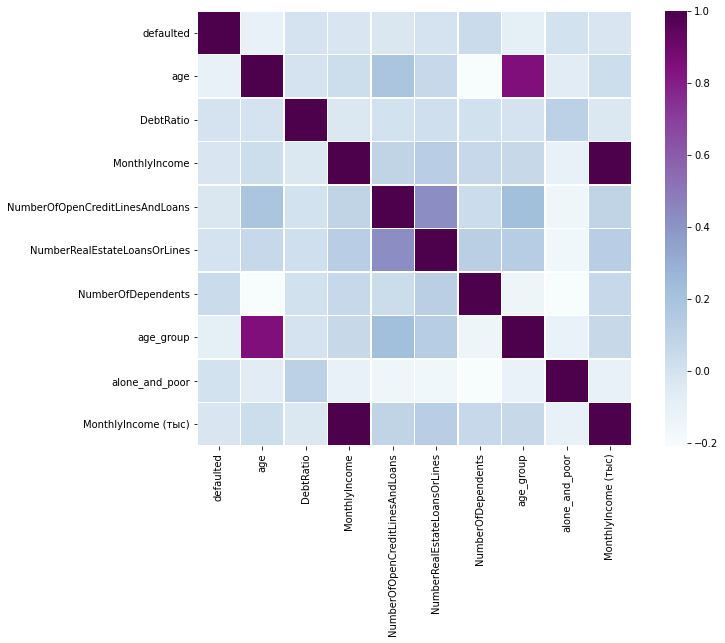

In [13]:
import seaborn as sns
corr_all = df_nonull.corr()

fig, ax0 = plt.subplots(figsize = (12, 8))
sns.heatmap(corr_all,
            square = True, linewidths = .5, ax = ax0,cmap = "BuPu")    
plt.show()

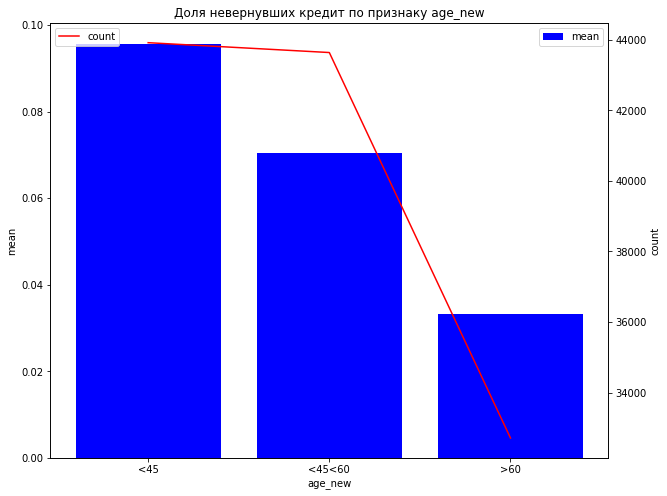

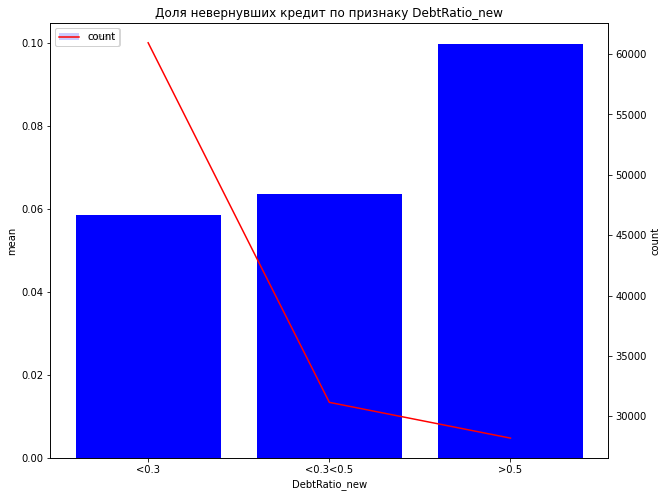

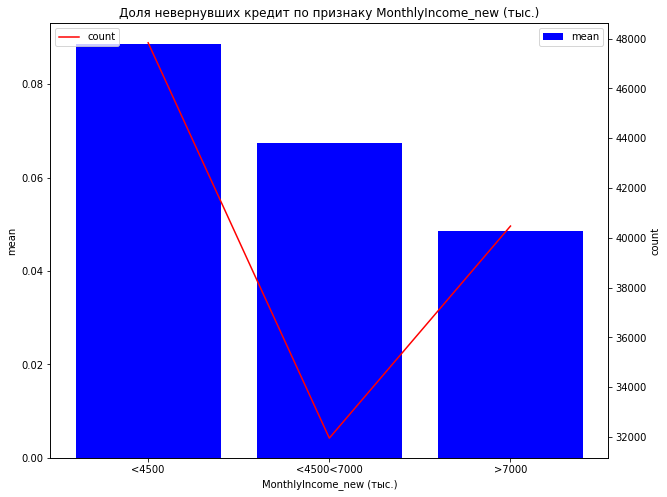

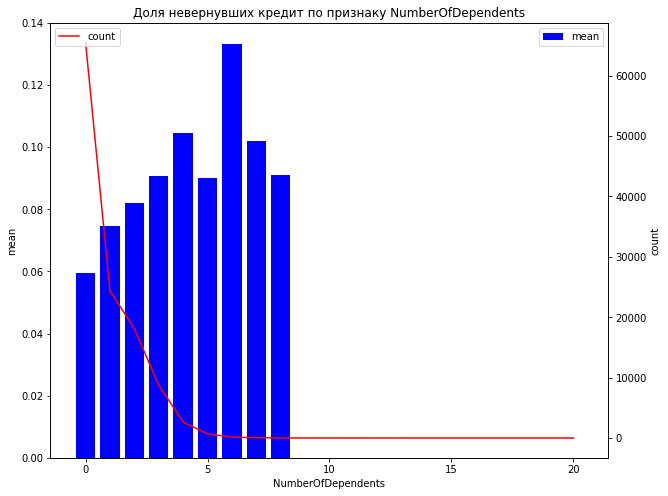

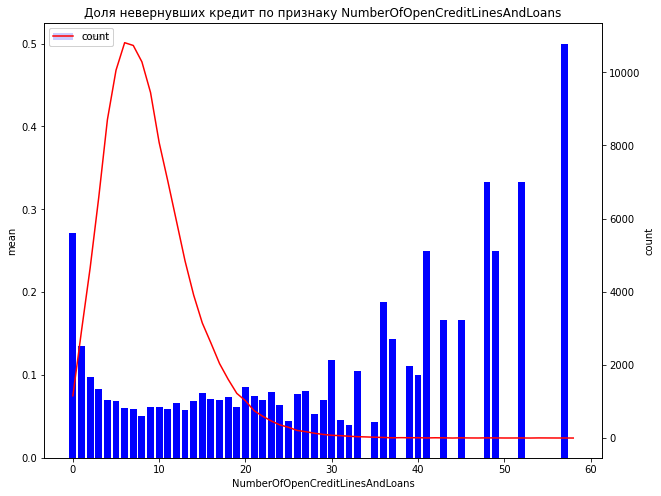

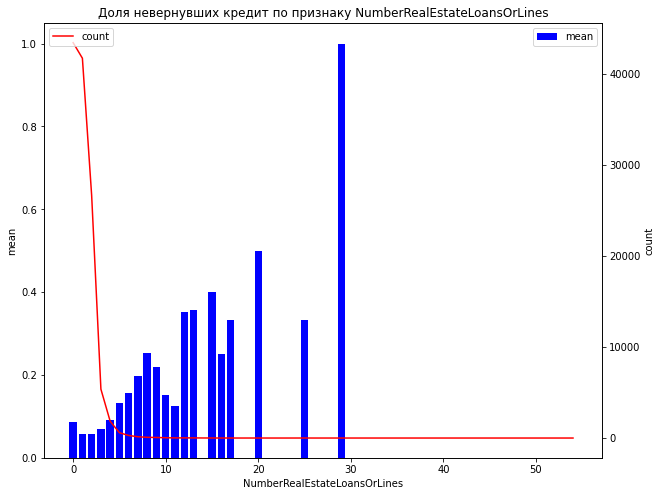

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline
for i in ['age_new', 'DebtRatio_new','MonthlyIncome_new (тыс.)','NumberOfDependents','NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines']:
    
    df_grouped = df_nonull.groupby([i])["defaulted"].agg(['count', 'mean'])
    
    fig, ax1 = plt.subplots(figsize=(10,8))
    ax1.set_title("Доля невернувших кредит по признаку {}".format(i))
    ax1.set_xlabel(i)
    ax1.set_ylabel('mean')
    ax1.bar(df_grouped.index.values,df_grouped['mean'].values, label ='mean', color ="b" )
    ax2 = ax1.twinx()  
    ax2.set_ylabel('count')
    ax2.plot(df_grouped.index.values ,df_grouped['count'].values, label ='count', color ="r")
    ax1.legend()  
    ax2.legend(loc='upper left')  
    plt.show()
    
  

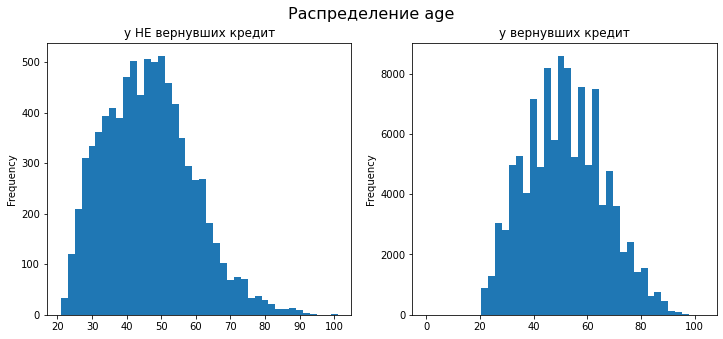

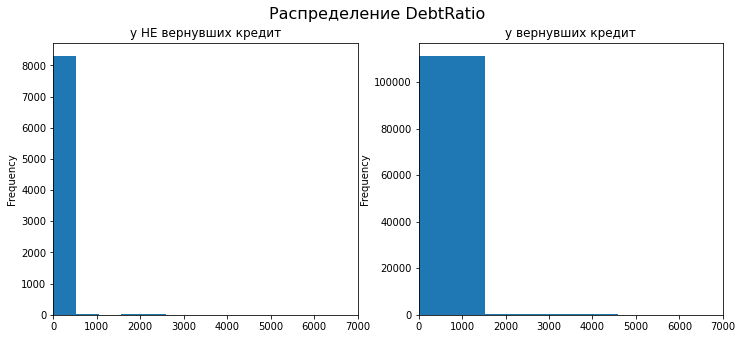

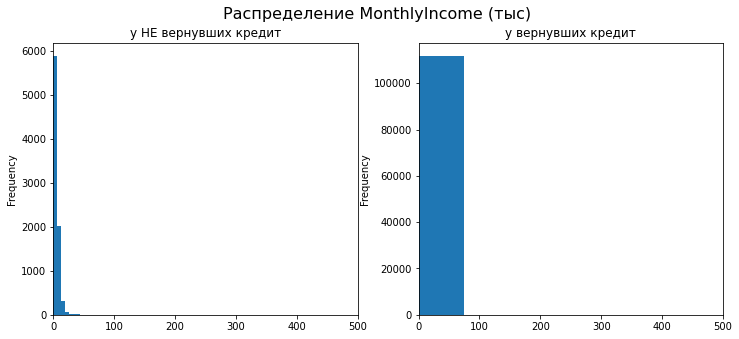

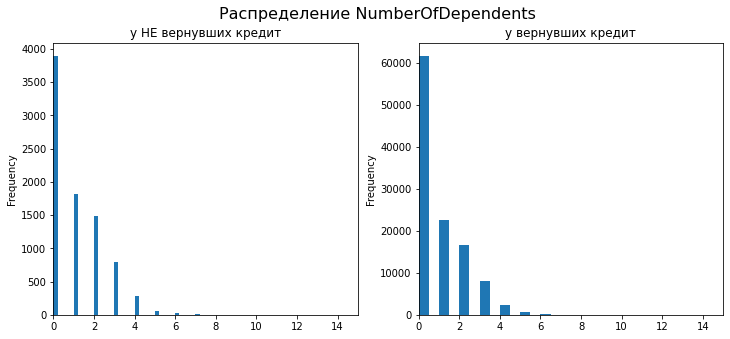

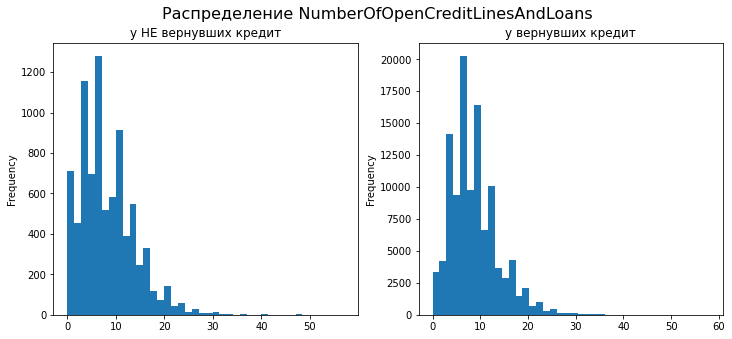

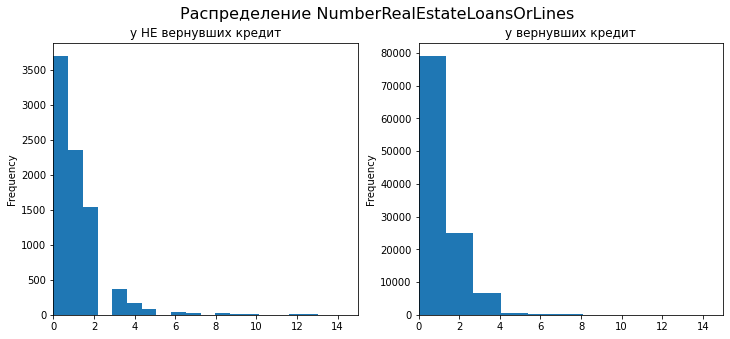

In [15]:

for i in ['age', 'DebtRatio','MonthlyIncome (тыс)','NumberOfDependents','NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines']:
    fig = plt.figure(figsize = (12,5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
   # plt.subplots_adjust(wspace=0.8)
    
    fig.suptitle("Распределение {}".format (i), fontsize=16)
    (df_nonull[df_nonull["defaulted"] == 1][i]).plot.hist(bins=40, ax=ax1)
    (df_nonull[df_nonull["defaulted"] == 0][i]).plot.hist(bins=40, ax=ax2)
    ax1.set_title  ("у НЕ вернувших кредит")
    ax2.set_title  ("у вернувших кредит")
    if i == 'NumberOfDependents':
        ax1.set_xlim(0,15)
        ax2.set_xlim(0,15)
    elif i == 'NumberRealEstateLoansOrLines':  
        ax1.set_xlim(0,15)
        ax2.set_xlim(0,15)
    elif i == 'DebtRatio':
        ax1.set_xlim(0,7000)
        ax2.set_xlim(0,7000)
    elif i == 'MonthlyIncome (тыс)':  
        ax1.set_xlim(0,500)
        ax2.set_xlim(0,500)
    plt.show()

В-целом, исходя из графиков, вероятность невозврата скорее всего коррелируетс возрастом, уровенем дохода,  debtratio,количеством иждивенцев и наличием других кредитов. 


## Построим скоринговую модель (классификация)

Для более точной оценки построим скоринговую модель

In [16]:
# Данные для анализа
df_X = df_nonull[[ 'age', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines',
       'NumberOfDependents']]
df_target = df_nonull["defaulted"].values


In [17]:
# Разделим на тестовую и обучающую выборки
X_train, X_test, y_train, y_test = train_test_split(df_X, df_target, train_size = 0.7, random_state = 1234)

In [18]:
from tqdm import tqdm_notebook
ensemble.RandomForestClassifier

sklearn.ensemble._forest.RandomForestClassifier

## Используем ТРИ модели и сравним их метрики качества
(RandomForestClassifier, XGBClassifier, CatBoostClassifier)

In [19]:
estimatorRFC = ensemble.RandomForestClassifier(n_estimators = 50, 
                                                min_samples_split=5, 
                                                random_state=1)
estimatorRFC.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [20]:
estimatorXGB = xgb.XGBClassifier(learning_rate=0.15, 
                                  max_depth=8, 
                                  n_estimators=50)
estimatorXGB.fit(X_train, y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=50, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [21]:
estimatorCB = CatBoostClassifier(iterations=100,
                           learning_rate=1,
                           depth=2)
estimatorCB.fit(X_train, y_train)


0:	learn: 0.2827588	total: 63ms	remaining: 6.24s
1:	learn: 0.2491218	total: 73.9ms	remaining: 3.62s
2:	learn: 0.2429143	total: 84.8ms	remaining: 2.74s
3:	learn: 0.2405755	total: 95.6ms	remaining: 2.29s
4:	learn: 0.2389902	total: 106ms	remaining: 2.02s
5:	learn: 0.2378795	total: 117ms	remaining: 1.83s
6:	learn: 0.2370075	total: 128ms	remaining: 1.7s
7:	learn: 0.2367163	total: 139ms	remaining: 1.59s
8:	learn: 0.2358592	total: 150ms	remaining: 1.51s
9:	learn: 0.2355800	total: 161ms	remaining: 1.45s
10:	learn: 0.2352805	total: 172ms	remaining: 1.39s
11:	learn: 0.2349661	total: 183ms	remaining: 1.34s
12:	learn: 0.2347655	total: 194ms	remaining: 1.3s
13:	learn: 0.2344168	total: 206ms	remaining: 1.26s
14:	learn: 0.2342838	total: 217ms	remaining: 1.23s
15:	learn: 0.2340707	total: 227ms	remaining: 1.19s
16:	learn: 0.2339324	total: 238ms	remaining: 1.16s
17:	learn: 0.2337634	total: 248ms	remaining: 1.13s
18:	learn: 0.2337154	total: 259ms	remaining: 1.1s
19:	learn: 0.2335305	total: 273ms	remainin

Найдем ошибки для каждой модели

In [22]:

estimatorRFC.predict(X_test)
estimatorXGB.predict(X_test)
estimatorCB.predict(X_test)
print("accuracy RFC", sum(np.array(y_test) == estimatorRFC.predict(X_test))/len(np.array(y_test)))
print("accuracy XGB", sum(np.array(y_test) == estimatorXGB.predict(X_test))/len(np.array(y_test)))
print("accuracy CB", sum(np.array(y_test) == estimatorCB.predict(X_test))/len(np.array(y_test)))

accuracy RFC 0.9293256838779413
accuracy XGB 0.9301294310024667
accuracy CB 0.9302680080929021


В-целом у всех моделей хороший и близкий результат

Оценим вероятность вовзрата кредита у следующих клиентов (из файла df_to_predict)

In [23]:
estimatorXGB.predict_proba(df_to_predict)
#estimatorXGB.predict(df_to_predict)

array([[0.87874293, 0.12125707],
       [0.94651157, 0.05348844],
       [0.9833245 , 0.01667544],
       [0.86050147, 0.13949853],
       [0.8415303 , 0.15846968]], dtype=float32)

Интерпретация: вероятность возврата первым клиентом около 88%, вторым - 95% и т.д.

### Карта признаков Shap

Построим карту признаков, наиболее влияющих на возврат кредитов, исходя из классификационной модели XGB

In [24]:
!pip install shap
import shap
shap.initjs()

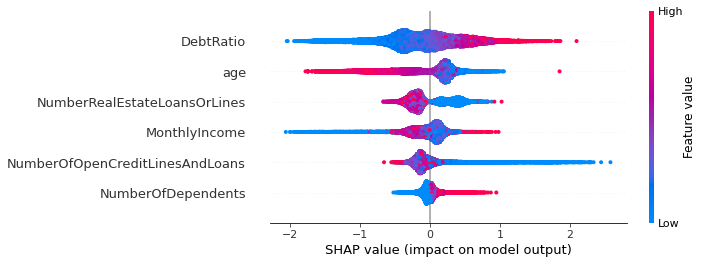

In [25]:
explainer = shap.TreeExplainer(estimatorXGB, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


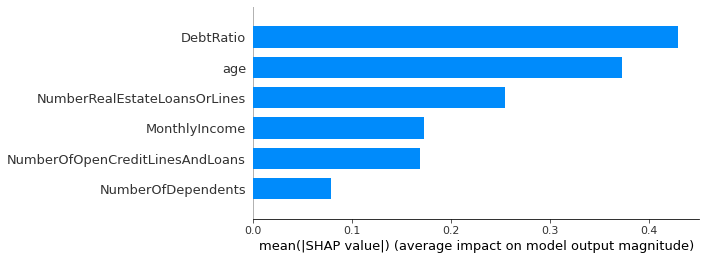

In [26]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

По карте признаков:
 
Наиболее влияемые на невозврат кредита факторы - это debtration (положительная зависимость) и возраст (отрицательная зависимость).
В-целом, положительная корреляция с debtration и numberofindependents, отрицательная с возраст, estate loans и creditlines